In [ ]:
import copy
import os
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import pyref.fitting as fit
import sigfig
from matplotlib.figure import Figure
from refnx.analysis import GlobalObjective, Transform

CPU_COUNT = os.cpu_count()

# Load the Data Files


Dataset loaded from reflectivity_data.parquet


(<Axes: ylabel='$R$'>, <Axes: xlabel='$q (\\AA^{-1})$'>)

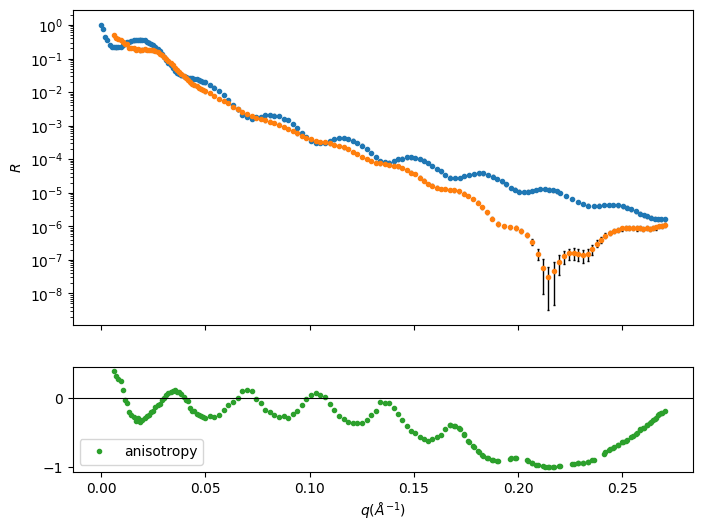

In [ ]:
def load_reflectivity_dataset(filename):
    """
    Load reflectivity dataset from a parquet file.

    Parameters
    ----------
    filename : str
        Input filename (should be a .parquet file)

    Returns
    -------
    dict
        Dictionary containing XrayReflectDataset objects with energy keys
    """
    # Load the DataFrame
    df_load = pl.read_parquet(filename)

    # Reconstruct the data dictionary
    data_reconstructed = {}

    # Group by energy
    for group_key, group_data in df_load.group_by("energy"):
        energy_val = group_key[0]  # Extract energy value from the group key tuple

        # Extract arrays
        Q = group_data["Q"].to_numpy()
        R = group_data["R"].to_numpy()
        dR = group_data["dR"].to_numpy()

        # Create XrayReflectDataset
        dataset = fit.XrayReflectDataset(data=(Q, R, dR))
        data_reconstructed[str(energy_val)] = dataset

    print(f"Dataset loaded from {filename}")
    return data_reconstructed


# # Save the dataset to a parquet file
# save_reflectivity_dataset(data, "reflectivity_data.parquet")
# # Load the dataset back from the parquet file
loaded_data = load_reflectivity_dataset("reflectivity_data.parquet")
loaded_data["283.7"].plot(label="283.7 eV data")

# Load Optical Constants for Constraints and OOC instantiation


In [ ]:
import pickle

ooc = pd.read_csv("optical_constants.csv")
energy = [float(e) for e in loaded_data.keys()]
with open("fitting_results_fixed.pkl", "rb") as f:
    fitting_results = pickle.load(f)


def get_objective_at_energy(global_objective, energy):
    """
    Retrieve the GlobalObjective object for a specific energy from fitting results.

    Parameters
    ----------
    fitting_results : dict
        Dictionary containing fitting results with energy keys.
    energy : float
        The energy value for which to retrieve the GlobalObjective.

    Returns
    -------
    GlobalObjective
        The GlobalObjective object corresponding to the specified energy.
    """
    for o in global_objective.objectives:
        if np.isclose(o.model.energy, energy):
            return o
    raise ValueError(f"No objective found for energy {energy}")


def get_optical_constants(objective):
    """
    Extract optical constants from a GlobalObjective object for a specific energy.

    Parameters
    ----------
    global_objective : GlobalObjective
        The GlobalObjective object containing the fitting results.
    energy : float
        The energy value for which to extract the optical constants.

    Returns
    -------
    tuple
        A tuple containing (delta, beta) for the specified energy.
    """
    sld_spec = {
        "density": [],
        "rotation": [],
        "energy_offset": [],
        "tensor": [],
        "thickness": [],
        "roughness": [],
    }
    structure = objective.model.structure
    for layer in structure:
        sld = layer.sld
        sld_spec["density"].append(sld.density.value)
        sld_spec["rotation"].append(sld.rotation.value)
        sld_spec["energy_offset"].append(sld.energy_offset.value)
        tensor = sld.tensor
        sld_spec["tensor"].append(tensor)
        sld_spec["thickness"].append(layer.thick.value)
        sld_spec["roughness"].append(layer.rough.value)
    return sld_spec


slds = {}
for o in fitting_results.objectives:
    e = o.model.energy
    sld_spec = get_optical_constants(o)
    slds[str(e)] = sld_spec
slds

{'250.0': {'density': [np.float64(0.0),
   np.float64(1.4655185072454873),
   np.float64(1.6536033989187757),
   np.float64(1.8),
   np.float64(2.145078869107535),
   np.float64(2.4432714412232603)],
  'rotation': [np.float64(0.0),
   np.float64(0.8015911159304013),
   np.float64(1.2069625690959114),
   np.float64(0.9036337915490659),
   np.float64(0.0),
   np.float64(0.0)],
  'energy_offset': [np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649),
   np.float64(-0.0017356089472281649)],
  'tensor': [array([[0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j],
          [0.+0.j, 0.+0.j, 0.+0.j]]),
   array([[0.00275385+0.00035459j, 0.        +0.j        ,
           0.        +0.j        ],
          [0.        +0.j        , 0.00275385+0.00035459j,
           0.        +0.j        ],
          [0.        +0.j        , 0.        +0.j        ,
 

In [ ]:
with open("slds_dict.pkl", "wb") as f:
    pickle.dump(slds, f)
print("slds dictionary saved to slds_dict.pkl")

slds dictionary saved to slds_dict.pkl


In [ ]:
with open("slds_dict.pkl", "rb") as f:
    slds = pickle.load(f)

In [ ]:
ZNPC = "C32H16N8Zn"
MA = np.asin(np.sqrt(2 / 3))


def setp_from_tensor(slab):
    """Set parameters from tensor."""
    tensor = slab.sld.tensor
    uniaxial_measure = tensor[2, 2] - tensor[0, 0]
    isotropic = tensor.trace() / 3
    diso = isotropic.real
    biso = isotropic.imag
    dichroism = uniaxial_measure.imag
    birefringence = uniaxial_measure.real

    # Handle birefringence/delta parameters
    if np.isclose(birefringence, 0):
        slab.sld.delta.setp(vary=True, bounds=(diso * 0.5, diso * 2))
        slab.sld.birefringence.setp(value=0, vary=False)
    else:
        birefringent_bounds = (
            (0, 5 * birefringence) if birefringence > 0 else (5 * birefringence, 0)
        )
        isotropic_bounds = (
            diso - 5 * abs(birefringence),
            diso + 5 * abs(birefringence),
        )
        slab.sld.birefringence.setp(vary=True, bounds=birefringent_bounds)
        slab.sld.delta.setp(vary=True, bounds=isotropic_bounds)

    # Set constraints for xx and zz components
    slab.sld.xx.setp(vary=None, constraint=slab.sld.delta - slab.sld.birefringence)
    slab.sld.zz.setp(vary=None, constraint=slab.sld.delta + slab.sld.birefringence)

    # Handle dichroism/beta parameters
    if np.isclose(dichroism, 0):
        slab.sld.beta.setp(vary=True, bounds=(biso * 0.5, biso * 2))
        slab.sld.dichroism.setp(value=0, vary=False)
    else:
        dichroic_bounds = (0, 5 * dichroism) if dichroism > 0 else (5 * dichroism, 0)
        isotropic_bounds = (
            max(biso - 5 * abs(dichroism), 0),
            biso + 5 * abs(dichroism),
        )
        slab.sld.dichroism.setp(vary=True, bounds=dichroic_bounds)
        slab.sld.beta.setp(vary=True, bounds=isotropic_bounds)

    # Set constraints for ixx and izz components
    slab.sld.ixx.setp(vary=None, constraint=slab.sld.beta - slab.sld.dichroism)
    slab.sld.izz.setp(vary=None, constraint=slab.sld.beta + slab.sld.dichroism)

    return slab


def vacuum(energy):
    """Vacuum."""
    slab = fit.MaterialSLD("", 0, name=f"Vacuum_{energy}")(0, 0)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=False)
    return slab


def substrate(energy, thick=0, rough=1.2, density=2.44):
    """Substrate."""
    slab = fit.MaterialSLD(
        "Si", density=density, energy=energy, name=f"Substrate_{energy}"
    )(thick, rough)
    slab.thick.setp(vary=False)
    slab.rough.setp(vary=False)
    slab.sld.density.setp(vary=True, bounds=(2.2, 3))
    return slab


def sio2(energy, thick=8.22, rough=6.153, density=2.15):
    """SiO2."""
    slab = fit.MaterialSLD(
        "SiO2", density=density, energy=energy, name=f"Oxide_{round(energy, 1)}"
    )(thick, rough)
    slab.thick.setp(vary=True, bounds=(8, 12))
    slab.rough.setp(vary=True, bounds=(0, 8))
    slab.sld.density.setp(vary=True, bounds=(2, 2.3))
    return slab


def contamination(energy, thick=4.4, rough=2, density=1.0):
    """Contamination."""
    name = f"Contamination_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=0.81, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(np.pi / 4, 7 * np.pi / 8))

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab


def surface(energy, thick=3.3, rough=1, density=1.0):
    """Surface."""
    name = f"Surface_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=0.8, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(0, np.pi / 4))

    slab.thick.setp(vary=True, bounds=(0, 12))
    slab.rough.setp(vary=True, bounds=(0, 5))
    return slab


def znpc(energy, thick=191, rough=8.8, density=1.61):
    """ZnPc."""
    name = f"ZnPc_{energy}"
    slab = fit.UniTensorSLD(
        ooc, density=density, rotation=1.35, energy=energy, name=name
    )(thick, rough)
    slab.sld.density.setp(vary=True, bounds=(1.2, 1.8))
    slab.sld.rotation.setp(vary=True, bounds=(MA, np.pi / 2))

    slab.thick.setp(vary=True, bounds=(180, 210))
    slab.rough.setp(vary=True, bounds=(2, 16))
    return slab


def construct_slab(
    energy,
    offset=0,
):
    """Construct the slab."""
    offset_energy = energy  # round(energy + offset, 1)
    slab = (
        vacuum(offset_energy)
        | surface(offset_energy)
        | znpc(offset_energy)
        | contamination(offset_energy)
        | sio2(offset_energy)
        | substrate(offset_energy)
    )
    slab.name = f"Monolayer_{energy + offset}"
    return slab


def construct_slab_from_old(
    energy,
):
    sld_spec = slds[str(energy)]
    offset_energy = energy  # + sld_spec["energy_offset"][0]
    surf = fit.SLD(sld_spec["tensor"][1], name=f"Surface_{energy}")(
        sld_spec["thickness"][1], sld_spec["roughness"][1]
    )
    if energy == 250.0:
        bulk = znpc(
            energy,
            thick=sld_spec["thickness"][2],
            rough=sld_spec["roughness"][2],
            density=sld_spec["density"][2],
        )
    else:
        bulk = fit.SLD(sld_spec["tensor"][2], name=f"Bulk_{energy}")(
            sld_spec["thickness"][2], sld_spec["roughness"][2]
        )
        setp_from_tensor(bulk)
    contam = fit.SLD(sld_spec["tensor"][3], name=f"Contamination_{energy}")(
        sld_spec["thickness"][3], sld_spec["roughness"][3]
    )
    setp_from_tensor(surf)
    setp_from_tensor(contam)
    slab = (
        vacuum(offset_energy)
        | surf
        | bulk
        | contam
        | sio2(
            offset_energy,
            thick=sld_spec["thickness"][4],
            rough=sld_spec["roughness"][4],
            density=sld_spec["density"][4],
        )
        | substrate(offset_energy, density=sld_spec["density"][5])
    )
    slab.name = f"Monolayer_{energy}"
    return slab


stacks = {str(round(e, 1)): construct_slab_from_old(e) for e in energy}
stacks.keys()

dict_keys(['282.9', '281.6', '281.4', '283.5', '289.0', '282.0', '282.3', '275.0', '284.2', '282.7', '285.1', '281.2', '283.3', '287.0', '281.8', '280.0', '283.7', '282.5', '250.0', '281.0', '283.1'])

In [ ]:
def safely_setp(slab, param, **kwargs):
    """Safely set parameters."""
    #  Check if the vary = True while the constraint is not None
    if kwargs.get("vary", False) and kwargs.get("constraint") is not None:
        kwargs["vary"] = None
    if hasattr(slab, param):
        getattr(slab, param).setp(**kwargs)

In [ ]:
for e in energy:
    for i, slab in enumerate(stacks[str(round(e, 1))]):
        if e == 283.7:
            continue
        safely_setp(
            slab,
            "thick",
            vary=None,
            constraint=stacks["283.7"][i].thick,
        )
        safely_setp(
            slab,
            "rough",
            vary=None,
            constraint=stacks["283.7"][i].rough,
        )
        if i == 0 or i == len(stacks[str(round(e, 1))]) - 1:
            safely_setp(
                slab.sld,
                "density",
                vary=None,
                constraint=stacks["283.7"][i].sld.density,
            )
            safely_setp(
                slab.sld,
                "rotation",
                vary=None,
                constraint=stacks["283.7"][i].sld.rotation,
            )

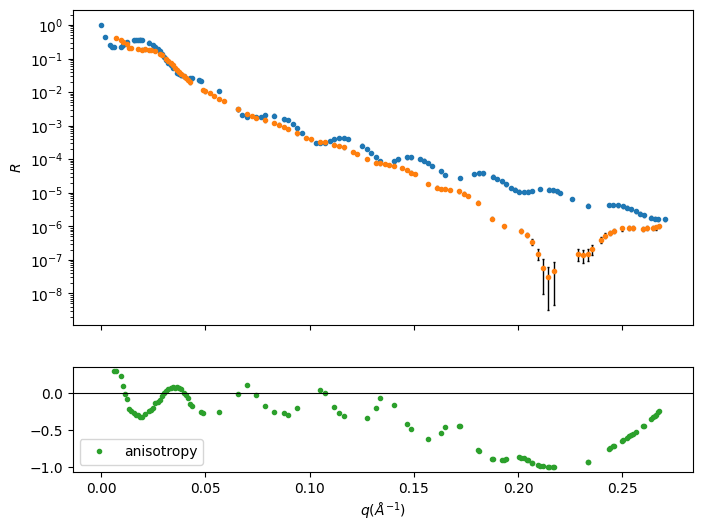

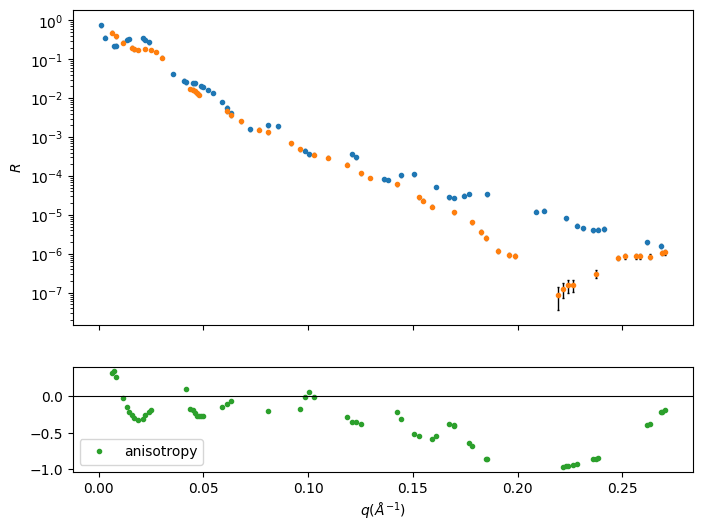

In [ ]:
from sklearn.model_selection import train_test_split

models = {
    str(e): fit.ReflectModel(
        stacks[str(round(e, 1))], pol="sp", name="Model " + str(e), energy=e
    )
    for e in energy
}

for name, model in models.items():
    if float(name) not in [250, 283.7]:
        model.bkg = 0
    # Constrain the energy offset to be the same for all models
    model.scale_p.setp(vary=True, bounds=(0.8, 1.2))
    model.scale_s.setp(vary=True, bounds=(0.8, 1.2))
    model.theta_offset_p.setp(vary=True, bounds=(-0.1, 0.1))
    model.theta_offset_s.setp(vary=True, bounds=(-0.1, 0.1))
    if model.name.endswith("283.7"):
        model.energy_offset.setp(
            vary=False,
            value=model.structure[0].sld.energy_offset.value,
            bounds=(-0.3, 0.3),
        )
    else:
        model.energy_offset.setp(vary=None, constraint=models["283.7"].energy_offset)


def dataset_subset(
    ds: fit.XrayReflectDataset, idx: np.ndarray
) -> fit.XrayReflectDataset:
    """
    Return a new dataset that contains only the points in *idx*.
    The new object has the same class as ``ds`` (e.g. XrayReflectDataset).
    """
    x = np.concatenate([ds.s.x, ds.p.x])[idx]
    y = np.concatenate([ds.s.y, ds.p.y])[idx]
    yerr = np.concatenate([ds.s.y_err, ds.p.y_err])[idx]
    return fit.XrayReflectDataset(data=(x, y, yerr), name=getattr(ds, "name", None))


# ------------------------------------------------------------------
# Full reflectivity q‑grid – this defines the number of samples
# ------------------------------------------------------------------
qs = loaded_data["283.7"].s.x
qp = loaded_data["283.7"].p.x
q_full = np.concatenate([qs, qp])
N = q_full.shape[0]

X_dummy = np.arange(N)[:, None]  # (N,1) – the column of indices
y_dummy = np.zeros(N)  # not used, but required by the API


# -------------------------------------------------------------------
# Splitting logic
# -------------------------------------------------------------------


def block_split(X, n_splits=5, shuffle=True, random_state=None):
    """
    Block-wise K-fold split for cross-validation that preserves spatial structure.

    This function creates contiguous blocks of data for training/testing, which is
    important for spatially correlated data like reflectivity measurements.

    Parameters
    ----------
    X : array-like
        Input data to split
    n_splits : int, default=5
        Number of folds
    shuffle : bool, default=True
        Whether to shuffle the data before splitting
    random_state : int, default=None
        Random state for reproducibility

    Returns
    -------
    list of tuples
        List of (train, test) index arrays for each split
    """
    n_samples = X.shape[0]
    indices = np.arange(n_samples)

    if shuffle:
        rng = np.random.RandomState(random_state)
        rng.shuffle(indices)

    # Calculate fold sizes
    fold_size = n_samples // n_splits
    remainder = n_samples % n_splits

    splits = []
    start = 0

    for i in range(n_splits):
        # Add one extra sample to first 'remainder' folds
        current_fold_size = fold_size + (1 if i < remainder else 0)
        end = start + current_fold_size

        test_indices = np.sort(indices[start:end])
        train_indices = np.sort(np.concatenate([indices[:start], indices[end:]]))

        splits.append((train_indices, test_indices))
        start = end

    return [split[0] for split in splits], [split[1] for split in splits]


# ------------------------------------------------------------------
# Build an example dataset subset just to show how it works
# ------------------------------------------------------------------

ds_example = loaded_data["283.7"]
train, test = block_split(X_dummy, n_splits=3, shuffle=True, random_state=42)
ds_train = dataset_subset(ds_example, train[2])
ds_test = dataset_subset(ds_example, test[2])
ds_train.plot(label="Train")
ds_test.plot(label="Test")
plt.legend()

In [ ]:
from tqdm import tqdm


# -------------------------------------------------
# 1.  Helper functions  (as defined above)
# -------------------------------------------------
def reduced_chi2(obj):
    return obj.chisqr() / (obj.npoints - len(obj.varying_parameters()))


def rmsd(obj):
    return np.sqrt(obj.chisqr() / obj.npoints)


def aic(obj):
    return 2 * len(obj.varying_parameters()) - 2 * obj.logl()


def bic(obj):
    return len(obj.varying_parameters()) * np.log(obj.npoints) - 2 * obj.logl()


def path_length(param_history):
    """Calculate path length."""
    n_iter = len(param_history)
    path_len = 0.0
    if n_iter > 1:
        diffs = np.diff(np.stack(param_history), axis=0)
        path_len = np.sum(np.linalg.norm(diffs, axis=1))
    return path_len


# -------------------------------------------------
# 2.  Fit for a single weight
# -------------------------------------------------
def fit_one_weight(models, data, weight, cpu_workers=1, seed=None):
    models_copy = copy.deepcopy(models)
    struct_obj = fit.AnisotropyObjective(
        models_copy["283.7"], data["283.7"], logp_anisotropy_weight=float(weight)
    )
    de_gen, param_hist = [], []

    def de_callback(xk, convergence=None):
        de_gen.append(reduced_chi2(struct_obj))
        param_hist.append(xk.copy())
        return False

    fitter = fit.CurveFitter(struct_obj)
    fitter.fit(
        target="nlpost",
        method="differential_evolution",
        init="latinhypercube",
        workers=cpu_workers,
        updating="deferred",
        callback=de_callback,
    )

    return {
        "weight": weight,
        "obj": struct_obj,
        "success": True if len(param_hist) > 2 else False,
        "nfev": len(param_hist),
        "chi2": struct_obj.chisqr(),
        "red_chi2": reduced_chi2(struct_obj),
        "rmsd": rmsd(struct_obj),
        "logl": struct_obj.logl(),
        "aic": aic(struct_obj),
        "bic": bic(struct_obj),
        "de_history": np.array(de_gen),
        "param_history": np.array(param_hist),
        "path_length": path_length(param_hist),
    }


# -------------------------------------------------
# 3.  Sweep
# -------------------------------------------------
weights = np.linspace(0, 1, 100)
cpu = CPU_COUNT
seed = 42

results = []
for w in tqdm(weights, desc="Scanning anisotropy weight"):
    results.append(fit_one_weight(models, loaded_data, round(w, 1), cpu_workers=cpu))

df = pd.DataFrame(results)
df.set_index("weight", inplace=True)

Scanning anisotropy weight:   0%|          | 0/100 [00:00<?, ?it/s]Process ForkPoolWorker-627:
Process ForkPoolWorker-624:
Process ForkPoolWorker-597:
Process ForkPoolWorker-618:
Process ForkPoolWorker-607:
Process ForkPoolWorker-605:
Process ForkPoolWorker-613:
Process ForkPoolWorker-602:
Process ForkPoolWorker-614:
Process ForkPoolWorker-616:
Process ForkPoolWorker-622:
Process ForkPoolWorker-612:
Process ForkPoolWorker-606:
Process ForkPoolWorker-610:
Process ForkPoolWorker-621:
Process ForkPoolWorker-611:
Process ForkPoolWorker-619:
Process ForkPoolWorker-609:
Process ForkPoolWorker-608:
Process ForkPoolWorker-603:
Process ForkPoolWorker-598:
Process ForkPoolWorker-620:
Process ForkPoolWorker-628:
Process ForkPoolWorker-600:
Process ForkPoolWorker-625:
Process ForkPoolWorker-599:
Process ForkPoolWorker-617:
Traceback (most recent call last):
Process ForkPoolWorker-615:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback

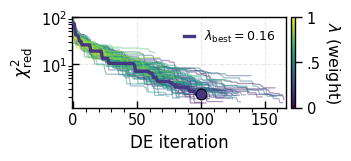

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# 1️⃣  Imports & global style
# ──────────────────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.colors import Normalize
import seaborn as sns

sns.set_context("paper", font_scale=1.2)  # PRL‑ready font size

df = pd.read_csv("de_sweep_results.csv")

# ──────────────────────────────────────────────────────────────────────────────
# 2️⃣  Prepare colour mapping based on λ (the "weight" column)
# ──────────────────────────────────────────────────────────────────────────────
# Ensure each de_history entry is a numpy array (avoids object-array issues)
df["de_history"] = df["de_history"].apply(lambda x: np.asarray(x))

# Optional: sort the dataframe by weight so that lower λ are plotted first
df = df.sort_values("weight").reset_index(drop=True)

weights = df["weight"].values
norm = Normalize(vmin=weights.min(), vmax=weights.max())
cmap = plt.get_cmap("viridis")  # good for colour‑blind readers

# ──────────────────────────────────────────────────────────────────────────────
# 3️⃣  Identify the "best" curve (lowest final χ²) – you can change the criterion
# ──────────────────────────────────────────────────────────────────────────────
# Use numpy arrays to safely index the last element (works even if dtype=object)
# determine the combined stopping time and chi sqr that gives the best fit in
# the fastest time
goodness = 1 / 2 * df["red_chi2"] + 1 / 2 * (df["nfev"] / df["nfev"].max())

best_idx = goodness.idxmin()
best_row = df.loc[best_idx]
lb = df.loc[]

# ──────────────────────────────────────────────────────────────────────────────
# 4️⃣  Plot (log‑scale χ², colour‑bar instead of legend)
# ──────────────────────────────────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(3.4, 1.5), constrained_layout=True)  # 2‑column width

# Plot every curve – thin lines for the “cloud”
for i, row in df.iterrows():
    # use the explicit weight column (safer than relying on .name)
    weight = row["weight"]
    history = np.asarray(row["de_history"])  # ensure numpy array
    colour = cmap(norm(weight))

    # Thicker, highlighted line for the best λ
    if i == best_idx:
        ax.plot(
            history,
            color=colour,
            lw=2.4,
            label=r"$\lambda_{\rm best}=%.3g$" % weight,
            zorder=5,  # bring to front
        )
        # optional marker at the end point
        ax.scatter(
            len(history) - 1,
            history[-1],
            color=colour,
            edgecolor="k",
            zorder=6,
            s=60,
        )
    else:
        ax.plot(
            history,
            color=colour,
            lw=0.9,
            alpha=0.45,
        )

# ──────────────────────────────────────────────────────────────────────────────
# 5️⃣  Axis cosmetics
# ──────────────────────────────────────────────────────────────────────────────
ax.set_xlabel(r"DE iteration", fontsize=12)
ax.set_ylabel(r"$\chi^{2}_{\rm red}$", fontsize=12)

# Use log‑scale if χ² spans > 1 order (uncomment if you prefer linear)
ax.set_yscale("log")

# Automatic limits – compute per-history minima/maxima then global min/max
mins = [np.min(h) for h in df["de_history"]]
maxs = [np.max(h) for h in df["de_history"]]
ymin, ymax = float(np.min(mins)), float(np.max(maxs))

# If using log scale, ensure ymin > 0 (find smallest positive value if any)
if ax.get_yscale() == "log" and ymin <= 0:
    positive_mins = [np.min(h[h > 0]) for h in df["de_history"] if np.any(h > 0)]
    if positive_mins:
        ymin = float(np.min(positive_mins))
    else:
        ymin = 1e-12

ax.set_ylim(ymin * 0.8, 1e2)
ax.set_xlim(-1, max(len(h) for h in df["de_history"]) + 1)

# Minor ticks + faint grid lines
ax.minorticks_on()
ax.grid(True, alpha=0.3, linestyle="--")
ax.tick_params(direction="in")

# ──────────────────────────────────────────────────────────────────────────────
# 6️⃣  Colour‑bar (acts as a legend for λ)
# ──────────────────────────────────────────────────────────────────────────────
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # dummy for colour‑bar
cbar = fig.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label(r"$\lambda$ (weight)", rotation=270, labelpad=15)
# use only 3 tickes for clarity
cbar.set_ticks([0, 0.5, 1])
cbar.set_ticklabels(["0", ".5", "1"])

# If you still want a tiny legend for the highlighted curve:
ax.legend(
    loc="upper right",
    handlelength=0.8,
    fontsize=9,
    frameon=False,
)

# ──────────────────────────────────────────────────────────────────────────────
# 7️⃣  Save as vector PDF (ready for LaTeX inclusion)
# ──────────────────────────────────────────────────────────────────────────────
fig.savefig("fig4.png", dpi=300, transparent=False)
plt.show()


In [ ]:
df.to_csv("anisotropy_weight_scan.csv")

In [ ]:
def plot(  # type: ignore
    obj,
    samples=0,
    model=None,
    ax=None,
    ax_anisotropy=None,
    color_err=("C0", "C1", "C2"),
    color_fit=("C0", "C1", "C2"),
    data_kwargs=None,
    model_kwargs=None,
    show_s=True,
    show_p=True,
    show_anisotropy=True,
):
    """
    Plot function that includes anisotropy information.

    Parameters
    ----------
    samples : int, optional
        Number of sample curves to plot from MCMC chain
    model : array-like, optional
        Model data to plot
    ax : matplotlib.Axes, optional
        Axes for reflectivity plot
    ax_anisotropy : matplotlib.Axes, optional
        Axes for anisotropy plot
    data_kwargs : dict, optional
        Keyword arguments for data plotting
    model_kwargs : dict, optional
        Keyword arguments for model plotting
    show_s : bool, optional
        Whether to show s-polarization data
    show_p : bool, optional
        Whether to show p-polarization data
    show_anisotropy : bool, optional
        Whether to show anisotropy plot

    Returns
    -------
    tuple
        (ax, ax_anisotropy) - matplotlib axes objects
    """
    import matplotlib.pyplot as plt

    if data_kwargs is None:
        data_kwargs = {}
    if model_kwargs is None:
        model_kwargs = {}

    # Set up axes
    if ax is None:
        if show_anisotropy:
            fig, axs = plt.subplots(
                nrows=2,
                sharex=False,
                figsize=(8, 6),
                gridspec_kw={"height_ratios": [3, 1]},
            )
            ax = axs[0]
            ax_anisotropy = axs[1]
        else:
            fig, ax = plt.subplots(figsize=(8, 4))
            ax_anisotropy = None
    elif ax_anisotropy is None and show_anisotropy:
        # Get the figure from the provided axis
        fig = ax.figure
        gs = fig.add_gridspec(2, 1, height_ratios=[3, 1], hspace=0)
        ax_anisotropy = fig.add_subplot(gs[1], sharex=ax)

    # Check if we have separate s and p polarization data
    has_separate_pol = hasattr(obj.data, "s") and hasattr(obj.data, "p")

    # Plot data
    if has_separate_pol:
        # Plot s-polarization if requested
        if show_s:
            ax.errorbar(
                obj.data.s.x,  # type: ignore
                obj.data.s.y,  # type: ignore
                obj.data.s.y_err,  # type: ignore
                label=f"{obj.data.name} s-pol" if obj.data.name else "s-pol",
                marker="o",
                color=color_err[0],
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k",
                **data_kwargs,
            )

            # Calculate s-polarization model
            original_pol = obj.model.pol
            obj.model.pol = "s"
            s_model = obj.model(obj.data.s.x)  # type: ignore
            ax.plot(
                obj.data.s.x,  # type: ignore
                s_model,
                color=color_fit[0],
                label="s-pol fit",
                zorder=20,
                **model_kwargs,
            )
            obj.model.pol = original_pol

        # Plot p-polarization if requested
        if show_p:
            ax.errorbar(
                obj.data.p.x,  # type: ignore
                obj.data.p.y,  # type: ignore
                obj.data.p.y_err,  # type: ignore
                label=f"{obj.data.name} p-pol" if obj.data.name else "p-pol",
                marker="o",
                color=color_err[1],
                ms=3,
                lw=0,
                elinewidth=1,
                capsize=1,
                ecolor="k",
                **data_kwargs,
            )

            # Calculate p-polarization model
            original_pol = obj.model.pol
            obj.model.pol = "p"
            p_model = obj.model(obj.data.p.x)  # type: ignore
            ax.plot(
                obj.data.p.x,  # type: ignore
                p_model,
                color=color_fit[1],
                label="p-pol fit",
                zorder=20,
                **model_kwargs,
            )
            obj.model.pol = original_pol
    else:
        # Handle combined data case
        ax.errorbar(
            obj.data.x,
            obj.data.y,
            obj.data.y_err,
            label=obj.data.name,
            marker="o",
            color=color_err[0],
            ms=3,
            lw=0,
            elinewidth=1,
            capsize=1,
            ecolor="k",
            **data_kwargs,
        )

        # Plot combined model
        model = obj.generative()
        _, _, model_transformed = obj._data_transform(model=model)

        if samples > 0:
            # Get sample curves from MCMC chain
            models = []
            for curve in obj._generate_generative_mcmc(ngen=samples):
                _, _, model_t = obj._data_transform(model=curve)
                models.append(model_t)
            models = np.array(models)

            # Show 1-sigma and 2-sigma confidence intervals
            ax.fill_between(
                obj.data.x,
                np.percentile(models, 16, axis=0),  # type: ignore
                np.percentile(models, 84, axis=0),  # type: ignore
                color=color_fit[1],
                alpha=0.5,
            )
            ax.fill_between(
                obj.data.x,
                np.percentile(models, 2.5, axis=0),  # type: ignore
                np.percentile(models, 97.5, axis=0),  # type: ignore
                color=color_fit[1],
                alpha=0.2,
            )

        # Plot the fit
        ax.plot(
            obj.data.x,
            model_transformed,  # type: ignore
            color=color_fit[1],
            label="fit",
            zorder=20,
            **model_kwargs,
        )

    # Plot anisotropy if enabled
    if (
        ax_anisotropy is not None
        and show_anisotropy
        and hasattr(obj.data, "anisotropy")
    ):
        ax_anisotropy.set_ylabel("Anisotropy")

        # Plot anisotropy model
        ax_anisotropy.plot(
            obj.data.anisotropy.x,  # type: ignore
            obj.model.anisotropy(obj.data.anisotropy.x),  # type: ignore
            color=color_fit[2],
            zorder=20,
            label="model",
        )

        # Plot anisotropy data
        ax_anisotropy.plot(
            obj.data.anisotropy.x,  # type: ignore
            obj.data.anisotropy.y,  # type: ignore
            color=color_err[2],
            marker="o",
            markersize=3,
            linestyle="None",
            label="data",
        )

        ax_anisotropy.legend()
        ax_anisotropy.axhline(0, color="k", ls="-", lw=plt.rcParams["axes.linewidth"])
        ax_anisotropy.set_xlabel(r"$q (\AA^{-1})$")

    # Finalize styling
    ax.set_ylabel("Reflectivity")
    ax.set_yscale("log")
    ax.legend()

    return ax, ax_anisotropy


def plot_reflectivity_and_structure(global_obj, figsize=(12, 10)) -> tuple[Figure, Any]:
    """
    Plot reflectivity data and structure profiles for a global objective.

    Parameters:
    -----------
    global_obj : GlobalObjective
        The global objective containing multiple objectives
    stacks : dict
        Dictionary of structure stacks with energy keys
    energy_labels : list, optional
        List of energy labels for plotting. If None, uses stack keys.
    figsize : tuple, optional
        Figure size (width, height)

    Returns:
    --------
    fig, ax : matplotlib figure and axes
    """
    objectives = global_obj.objectives
    energy_labels = [o.model.energy for o in objectives]
    stacks = {str(o.model.energy): o.model.structure for o in objectives}
    n_objectives = len(objectives)

    # Create figure and axes
    fig, ax = plt.subplots(
        nrows=n_objectives,
        ncols=2,
        figsize=figsize,
        gridspec_kw={
            "hspace": 0.25,
            "wspace": 0.15,
            "width_ratios": [2.5, 1],
        },
    )

    # Handle single objective case
    if n_objectives == 1:
        ax = ax.reshape(1, -1)

    # Define colors for consistency
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

    # Plot objectives and structures
    for i in range(n_objectives):
        if i >= len(objectives):
            break

        o = objectives[i]
        color = colors[i % len(colors)]

        # Plot reflectivity data
        plot(
            o,
            ax=ax[i][0],
            show_anisotropy=False,
            color_fit=("k", "k", "k"),
            model_kwargs={"lw": 0.5},
        )
        ax[i][0].set_ylabel(None, fontsize=12, fontweight="bold")
        ax[i][0].set_yscale("log")
        ax[i][0].grid(True, alpha=0.3, linestyle="--")
        ax[i][0].tick_params(direction="in", labelsize=10)

        # Add energy label as text box
        ax[i][0].text(
            0.55,
            0.95,
            energy_labels[i],
            transform=ax[i][0].transAxes,
            fontsize=11,
            fontweight="bold",
            bbox=dict(
                boxstyle="round,pad=0.3",
                facecolor="white",
                edgecolor=color,
                linewidth=1.5,
            ),
            verticalalignment="top",
            zorder=10,
        )

        # Custom legend for reflectivity
        if i == 0:
            ax[i][0].legend(
                ["s-pol", "p-pol"],
                loc="upper right",
                frameon=True,
                fancybox=False,
                fontsize=10,
            )
        else:
            if ax[i][0].get_legend():
                ax[i][0].get_legend().remove()

        # Plot structure (SLD profile)
        stack_key = list(stacks.keys())[i]
        stack = stacks[stack_key]
        stack.plot(ax=ax[i][1])
        ax[i][1].grid(True, alpha=0.3, linestyle="--")
        ax[i][1].tick_params(direction="in", labelsize=10)

        # Format y-axis for SLD to show in scientific notation
        ax[i][1].ticklabel_format(
            style="scientific", axis="y", scilimits=(0, 0), useMathText=True
        )

        # Remove individual legends except for the top structure plot
        if i == 0:
            ax[i][1].legend(
                loc="upper center",
                ncol=2,
                fontsize=9,
                frameon=True,
                fancybox=False,
            )
        else:
            if ax[i][1].get_legend():
                ax[i][1].get_legend().remove()

    # Set up x-axis labels
    ax[n_objectives - 1][0].set_xlabel("Q (Å⁻¹)", fontsize=12, fontweight="bold")

    # Set y-axis labels for structure plots
    for i in range(n_objectives):
        ax[i][1].set_ylabel(None, fontsize=12, fontweight="bold")
        if i < n_objectives - 1:
            ax[i][1].set_xlabel("")
        else:
            ax[i][1].set_xlabel("Distance (Å)", fontsize=12, fontweight="bold")

    # Set consistent x-axis limits for better comparison
    # for i in range(n_objectives):
    # ax[i][1].set_xlim(-10, 200)

    plt.tight_layout()
    plt.subplots_adjust(top=0.94)
    plt.show()

    return fig, ax

In [ ]:
best_ani = 0.16

_struct_obj = [
    fit.AnisotropyObjective(
        models["283.7"], loaded_data["283.7"], logp_anisotropy_weight=best_ani
    ),
    fit.AnisotropyObjective(
        models["250.0"], loaded_data["250.0"], logp_anisotropy_weight=best_ani
    ),
]
for o in _struct_obj:
    o.model.bkg.setp(vary=False, value=o.data.p.y.min())
    o.transform = Transform("logY")
struct_obj = fit.GlobalObjective(_struct_obj)
fitter = fit.CurveFitter(struct_obj)
fitter.fit(
    target="nlpost",
    method="differential_evolution",
    # init="latinhypercube",
    workers=CPU_COUNT,
    updating="deferred",
)

-113.3051847170052: : 102it [04:45,  2.80s/it]


             message: Optimization terminated successfully.
             success: True
                 fun: -114.58337097328145
                   x: [ 8.813e-01  9.363e-01 ...  2.178e-04  0.000e+00]
                 nit: 102
                nfev: 67212
          population: [[ 8.672e-01  9.292e-01 ...  3.675e-04 -6.156e-06]
                       [ 9.796e-01  1.073e+00 ...  4.955e-04 -1.225e-05]
                       ...
                       [ 8.744e-01  8.407e-01 ...  2.668e-04 -7.912e-06]
                       [ 8.535e-01  9.291e-01 ...  3.964e-04 -1.019e-05]]
 population_energies: [-1.146e+02 -1.117e+02 ... -1.110e+02 -1.112e+02]
                 jac: [ 1.243e-01  2.932e-01 ...  4.095e+02 -3.244e+02]
               covar: [[ 5.481e-03  5.759e-03 ...  6.965e-06 -1.368e-07]
                       [ 5.759e-03  7.401e-03 ...  6.335e-06 -1.769e-07]
                       ...
                       [ 6.965e-06  6.335e-06 ...  6.207e-08 -1.280e-09]
                       [-1.368e-07 

In [ ]:
objectives = [
    fit.AnisotropyObjective(
        models[str(e)], loaded_data[str(e)], logp_anisotropy_weight=best_ani
    )
    for e in energy
]

for objective in objectives:
    objective.transform = Transform("logY")
    if objective.model.energy in [250, 283.7]:
        objective.model.bkg.setp(vary=False, value=objective.data.p.y.min())

In [ ]:
best_obj = struct_obj.objectives[0]
for i, slab in enumerate(stacks["283.7"]):
    slab.thick.setp(
        value=best_obj.model.structure[i].thick.value,
    )
    slab.rough.setp(
        value=best_obj.model.structure[i].rough.value,
    )

for i, slab in enumerate(stacks["250.0"]):
    slab.thick.setp(
        vary=None,
        # value=best_obj.model.structure[i].thick.value,
        constraint=stacks["283.7"][i].thick,
    )
    slab.rough.setp(
        vary=None,
        # value=best_obj.model.structure[i].rough.value,
        constraint=stacks["283.7"][i].rough,
    )
    if i == 2:
        continue
    safely_setp(
        slab.sld,
        "density",
        vary=None,
        constraint=stacks["283.7"][i].sld.density,
    )
    safely_setp(
        slab.sld,
        "rotation",
        vary=None,
        constraint=stacks["283.7"][i].sld.rotation,
    )

struct_obj = fit.GlobalObjective([objectives[16], objectives[-3]])
print(struct_obj.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=0.88134 +/- 0.074, bounds=[0.8, 1.2]>
<Parameter:   'scale_p'   , value=0.936287 +/- 0.086, bounds=[0.8, 1.2]>
<Parameter:'theta_offset_s', value=0.00221407 +/- 0.047, bounds=[-0.1, 0.1]>
<Parameter:'theta_offset_p', value=-0.00461307 +/- 0.069, bounds=[-0.1, 0.1]>
<Parameter:'Surface_283.7_thick', value=1.77083 +/- 1.23 , bounds=[0.0, 11.063088443158598]>
<Parameter:'Surface_283.7_rough', value=7.03702 +/- 0.17 , bounds=[0.0, 8.823241700973194]>
<Parameter:'Surface_283.7_diso', value=0.00088582 +/- 0.000108, bounds=[-0.0061542103338947255, 0.004611484307021176]>
<Parameter:'Surface_283.7_biso', value=0.000926757 +/- 0.00014, bounds=[0.0, 0.0018969629365074947]>
<Parameter:'Surface_283.7_bire', value=-0.000389156 +/- 4.37e-05, bounds=[-0.005382847320457951, 0.0]>
<Parameter:'Surface_283.7_dichro', value=0 +/- 5.56e-05, bounds=[0.0, 0.00127095587

-114.86210834579832: : 115it [07:32,  3.94s/it]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

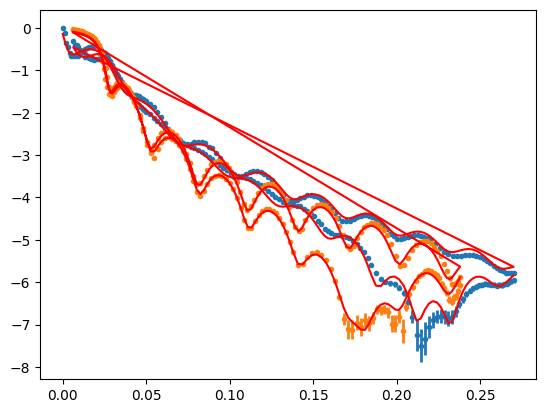

In [ ]:
fitter = fit.CurveFitter(struct_obj)
fitter.fit(
    target="nlpost",
    method="differential_evolution",
    workers=CPU_COUNT,
    updating="deferred",
)
struct_obj.plot()

/tmp/ipykernel_1623973/2694608493.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


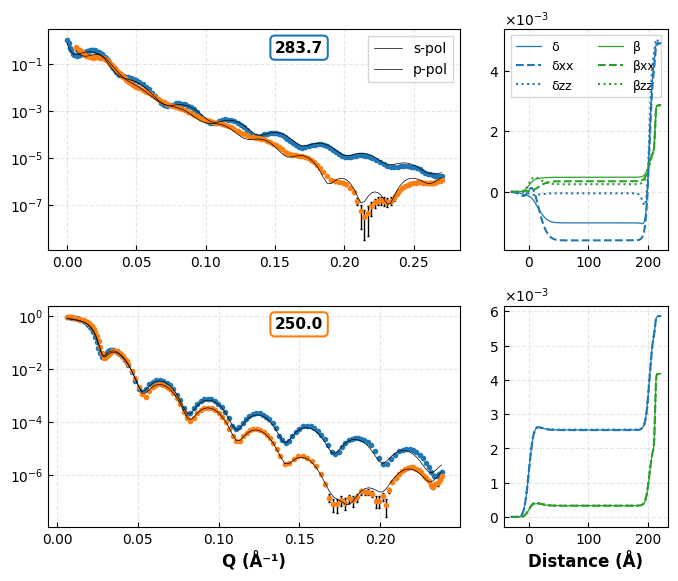

(<Figure size 800x600 with 4 Axes>,
 array([[<Axes: >, <Axes: >],
        [<Axes: xlabel='Q (Å⁻¹)'>, <Axes: xlabel='Distance (Å)'>]],
       dtype=object))

In [ ]:
plot_reflectivity_and_structure(struct_obj, figsize=(8, 6))

In [ ]:
structure = struct_obj.objectives[0].model.structure

In [ ]:
fit_objs = []

for o, e in zip(objectives, energy):
    print(f"Energy: {e} eV")
    o = copy.deepcopy(o)
    fitter = fit.CurveFitter(o)
    fitter.fit(
        target="nlpost",
        method="differential_evolution",
        workers=CPU_COUNT,
        updating="deferred",
    )
    fit_objs.append(o)
    o.plot()

Energy: 282.9 eV


-104.2831852044701: : 21it [00:17,  1.17it/s] 


Energy: 281.6 eV


-118.02429200458353: : 13it [00:12,  1.01it/s]


Energy: 281.4 eV


-118.41840905456665: : 16it [00:16,  1.05s/it]


Energy: 289.0 eV


-53.87834789574647: : 119it [01:00,  1.98it/s] 


Energy: 283.5 eV


-63.314847115591526: : 61it [00:44,  1.37it/s]


Energy: 282.0 eV


-117.09122013849871: : 17it [01:03,  3.72s/it]


Energy: 282.3 eV


-91.27083038503747: : 18it [00:27,  1.51s/it]


Energy: 275.0 eV


-125.68571540435475: : 12it [00:09,  1.22it/s]


Energy: 284.2 eV


-47.10190197638591: : 207it [01:01,  3.35it/s] 


Energy: 282.7 eV


-90.07741951150354: : 22it [00:26,  1.22s/it]


Energy: 285.1 eV


-58.66640790210792: : 270it [01:28,  3.07it/s] 


Energy: 281.2 eV


-118.70554949024871: : 14it [01:30,  6.44s/it]


Energy: 283.3 eV


-74.80658657261543: : 33it [00:30,  1.10it/s]


Energy: 287.0 eV


-53.10025172147885: : 106it [00:58,  1.83it/s] 


Energy: 281.8 eV


-117.69853403021624: : 14it [00:13,  1.03it/s]


Energy: 280.0 eV


-120.64674069838537: : 14it [00:02,  5.62it/s]

In [ ]:
obj_250 = fit_objs[-3]
print(obj_250.varying_parameters())

________________________________________________________________________________
Parameters:      None      
<Parameter:   'scale_s'   , value=0.8 +/- 0.0154, bounds=[0.8, 1.2]>
<Parameter:   'scale_p'   , value=0.83233 +/- 0.0157, bounds=[0.8, 1.2]>
<Parameter:'theta_offset_s', value=0.1 +/- 0.0513, bounds=[-0.1, 0.1]>
<Parameter:'theta_offset_p', value=0.1 +/- 0.0508, bounds=[-0.1, 0.1]>
<Parameter:'Surface_250.0_diso', value=0.0028026 +/- 0.000107, bounds=[0.0026981256710032673, 0.002802600686772467]>
<Parameter:'Surface_250.0_biso', value=0.000709188 +/- 0.000169, bounds=[0.00017729699841652618, 0.0007091879936661047]>
<Parameter:'Surface_250.0_bire', value=-5.22375e-05 +/- 3.54e-05, bounds=[-5.2237507884599944e-05, 0.0]>
<Parameter:'ZnPc_250.0_density', value=1.50661 +/- 0.0373, bounds=[1.2, 1.8]>
<Parameter:'ZnPc_250.0_rotation', value=1.40848 +/- 1.79 , bounds=[0.9553166181245093, 1.5707963267948966]>
<Parameter:'Contamination_250.0_diso', value=0.00335697 +/- 9.47e-05, bounds=[

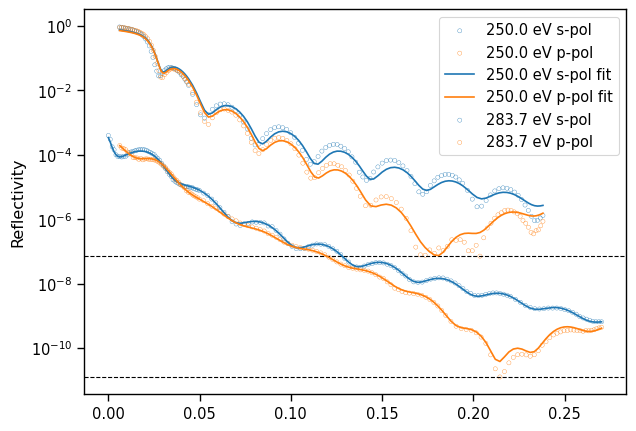

In [ ]:
long_q_energy = [250.0, 283.7]
pre_range = energy[: energy.index(283.7) + 1]
post_range = energy[energy.index(283.7) :]
#  Plot the data sets with 4 pannels, left long q, left mid pre_range, right mid
#  post_range, right blank

fig, axes = plt.subplots(
    ncols=1,
    figsize=(7, 5),
)
for i, e in enumerate(long_q_energy):
    o = fit_objs[energy.index(e)]
    data = loaded_data[str(e)]
    scale_factor = 50 ** (-2 * i)
    sns.scatterplot(
        x=data.s.x,
        y=data.s.y * scale_factor,
        marker="o",
        s=9,
        label=f"{e} eV s-pol",
        ax=axes,
        color="C0",
        edgecolor="C0",
        facecolor="none",
        alpha=1,
    )
    sns.scatterplot(
        x=data.p.x,
        y=data.p.y * scale_factor,
        marker="o",
        s=9,
        label=f"{e} eV p-pol",
        ax=axes,
        color="C1",
        edgecolor="C1",
        facecolor="none",
        alpha=1,
    )
    bkg = data.p.y.min()
    axes.axhline(bkg * scale_factor, color="k", ls="--", lw=0.8)
    #  Plot the fits
    o.model.bkg = bkg
    o.model.pol = "s"
    ss = o.model(data.s.x)
    axes.plot(data.s.x, ss * scale_factor, label=f"{e} eV s-pol fit", c="C0")
    o.model.pol = "p"
    pp = o.model(data.p.x)
    axes.plot(data.p.x, pp * scale_factor, label=f"{e} eV p-pol fit", c="C1")
    axes.set_yscale("log")
    axes.set_ylabel("Reflectivity")

In [ ]:
def fitting(
    obj: list[T],
    recursion_limit=2,
    workers=CPU,
) -> tuple[fit.GlobalObjective, fit.CurveFitter]:
    """
    Fit the model to the data using the provided objective.

    Parameters
    ----------
    obj : list[T]
        The list of objective function to minimize (can be AnisotropyObjective or
        GlobalObjective).
    recursion_limit : int, optional
        The number of times to recursively fit using differential evolution before refining with L-BFGS-B. Default is 2.
    workers : int, optional
        The number of parallel workers to use for fitting. Default is -1 (use all available).
    mcmc : bool, optional
        If True, perform MCMC sampling after fitting. Default is False.

    Returns
    -------
    tuple[fit.GlobalObjective, fit.CurveFitter]
        The fitted objective and the fitter used.
    """
    fit_objectives: list[T] = []
    for o in obj:
        fit_objectives.append(fit_dynamic(o))
    global_objective = fit.GlobalObjective(fit_objectives)  # type: ignore
    fitter = fit.CurveFitter(
        global_objective,
    )
    fitter.fit(
        target="nll",
        method="differential_evolution",
        polish=False,
        workers=workers,
        updating="deferred",
        maxiter=50,
    )
    kwargs = {"target": "nlpost", "method": "L-BFGS-B", "options": {"workers": workers}}
    for _ in range(recursion_limit - 1):
        try:
            fitter.fit(**kwargs)
            fit.fitters._fix_bounds(global_objective, by_bounds=True)
        except Exception as e:
            print(f"Error occurred during fitting: {e}")
            return global_objective, fitter

    return global_objective, fitter

In [ ]:
fit_obj, fitter = fitting(objectives, recursion_limit=2, workers=CPU)

11746it [12:27, 15.71it/s, batch: 45 | bound: 28 | nc: 1 | ncall: 1470412 | eff(%):  0.796 | loglstar: -7.275 <  0.640 <  0.124 | logz: -7.348 +/-  0.086 | stop:  0.980]       
11546it [09:33, 20.14it/s, batch: 46 | bound: 14 | nc: 1 | ncall: 1311780 | eff(%):  0.877 | loglstar: -5.403 <  0.218 < -1.215 | logz: -6.003 +/-  0.078 | stop:  0.980]       
11499it [09:40, 19.82it/s, batch: 47 | bound: 16 | nc: 1 | ncall: 1311241 | eff(%):  0.874 | loglstar: -4.514 <  0.755 < -0.196 | logz: -5.828 +/-  0.078 | stop:  0.989]       
12279it [15:08, 13.51it/s, batch: 41 | bound: 23 | nc: 1 | ncall: 1654624 | eff(%):  0.742 | loglstar:   -inf < -0.800 < -2.679 | logz: -12.383 +/-  0.119 | stop:  0.986]        
12478it [10:29, 19.81it/s, batch: 40 | bound: 17 | nc: 1 | ncall: 1706394 | eff(%):  0.729 | loglstar: -7.874 < -0.555 < -2.283 | logz: -17.303 +/-  0.139 | stop:  0.996]        
11539it [10:19, 18.63it/s, batch: 47 | bound: 23 | nc: 1 | ncall: 1342619 | eff(%):  0.858 | loglstar: -6.732 <

In [ ]:
import pickle

with open("fitting_results_free_model.pkl", "wb") as f:
    pickle.dump(fit_obj, f)

/tmp/ipykernel_623183/2694608493.py:367: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


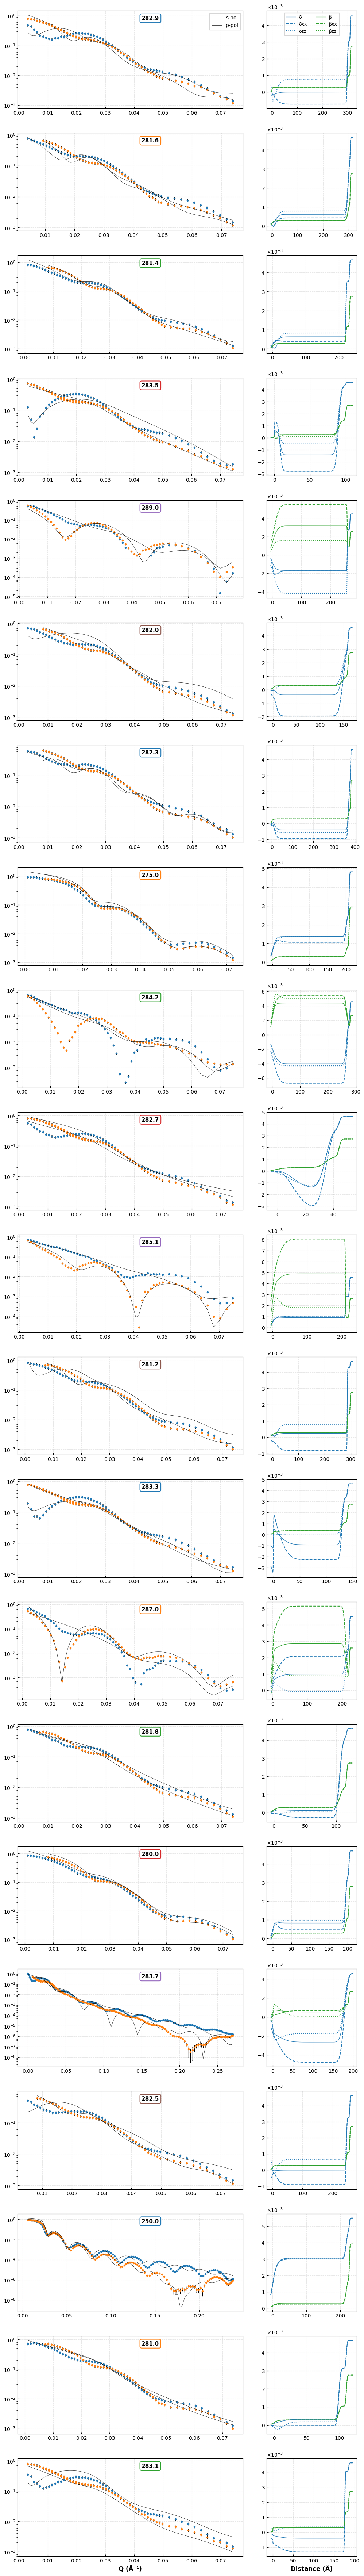

In [ ]:
plot_reflectivity_and_structure(fit_obj, figsize=(12, 4 * len(fit_obj.objectives)))
plt.show()